<a href="https://colab.research.google.com/github/IKKEM-Lin/colab/blob/main/graph_for_substance%26reaction_20230919.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 反应物质的提取、信息收集（需上传反应json文件）



### 1. 导入模块及定义公共函数

In [2]:
!pip install Levenshtein

import requests
import json
import time
from pathlib import Path
import re
from Levenshtein import distance

def get_concepts(name):
  res = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/concepts/name/JSON?name={name}").json()
  CIDs = res.get("ConceptsAndCIDs", {}).get("CID", [])
  return CIDs and CIDs[0]

def get_search_type(name):
  if " " in name:
    return "text"
  query = {"query":{"type":"validity","parameter":[{"name":"Query","string":"{name}"}]}}
  query = json.dumps(query)
  res = requests.get(f'https://pubchem.ncbi.nlm.nih.gov/unified_search/structure_search.cgi?format=json&queryblob={query}').json()
  validity = res.get("response", {}).get("validity", [])

  # print(res)
  smiles = [item.get("valid") for item in validity if item.get("type") == "SMILES"][0]
  smart = [item.get("valid") for item in validity if item.get("type") == "SMARTS"][0]
  formula = [item.get("valid") for item in validity if item.get("type") == "Formula"][0]
  cache = [item.get("valid") for item in validity if item.get("type") == "Cache"][0]

  if not formula:
    return "text"
  if len(name) < 4:
    return "formular"

  return not(smiles or smart or cache) and "formular" or "text"

def search_by_formular(name):
  query = {"query":{"type":"formula","parameter":[{"name":"FormulaQuery","string": str(name)},{"name":"UseCache","bool":False},{"name":"SearchTimeMsec","num":5000},{"name":"SearchMaxRecords","num":10},{"name":"allowotherelements","bool":False}]}}
  query = json.dumps(query)
  res = requests.get(f'https://pubchem.ncbi.nlm.nih.gov/unified_search/structure_search.cgi?format=json&queryblob={query}').json()
  hitcount = res.get("response", {}).get("hitcount", 0)
  if hitcount > 0:
    try:
      column = res.get("response", {}).get("table", {}).get("column", [])
      print(column, )
      cids = list(filter(lambda x: x.get("name") == "CID", column))[0].get("num", [])
      return cids
    except:
      pass
  return []

def search_by_text(name):
  names = name.split(" ")
  query = {"select":"*","collection":"compound","where":{"ands":[{"*":item} for item in names]},"order":["relevancescore,desc"],"start":1,"limit":10,"width":1000000,"listids":0}
  query = json.dumps(query)
  res = requests.get(f'https://pubchem.ncbi.nlm.nih.gov/sdq/sdqagent.cgi?infmt=json&outfmt=json&query={query}').json()
  compounds = [item.get("rows") for item in res.get("SDQOutputSet", []) if item.get("collection") == "compound"]
  return compounds and compounds[0]

def get_cid_detail(cid):
  res = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{cid}/JSON/").json()
  return res

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.1 MB/s eta 0:00:00


### 2. 抽取所有物质及其频次

In [4]:
all_reaction_file = "all_reaction.json"
all_substance_file = "all_uniq_substance.json"
substance_freqency_file = "freqency.json"

all_substance = []
all_uniq_substance = []
# substance_frequency = {}

def add_substance_from_reaction(reaction):
  def add_substance(substance_list):
    for item in substance_list:
      substance = isinstance(item, dict) and (item.get("name") or item.get("mf"))
      if not substance:
        continue
      if not isinstance(substance, str):
        continue
      all_substance.append(substance.strip())
  reactants = reaction.get("data", {}).get("reactants")
  catalysts = reaction.get("data", {}).get("catalysts")
  balance_gases = reaction.get("data", {}).get("balance_gases")
  solvents = reaction.get("data", {}).get("solvents")
  intermediates = reaction.get("data", {}).get("intermediates")
  products = reaction.get("data", {}).get("products")

  isinstance(reactants, list) and add_substance(reactants)
  # isinstance(catalysts, list) and add_substance(catalysts)
  # isinstance(solvents, list) and add_substance(solvents)
  isinstance(intermediates, list) and add_substance(intermediates)
  isinstance(products, list) and add_substance(products)


with open(all_reaction_file, "rb") as f:
  reactions = json.load(f)
  for reaction in reactions:
    add_substance_from_reaction(reaction)
  all_uniq_substance = list(set(all_substance))
  print(len(all_uniq_substance))
  # for ind, uniq_substance in enumerate(all_uniq_substance):
  #   print(f"start {ind}, {ind / len(all_uniq_substance)}")
  #   substance_frequency[uniq_substance] = all_substance.count(uniq_substance)

  with open(all_substance_file, "w") as fs:
    fs.write(json.dumps(all_uniq_substance))
  # with open(substance_freqency_file, "w") as fs:
  #   fs.write(json.dumps(substance_frequency))


14346


### 3. 初步筛选出可获取cid的物质

In [ ]:
cid_match_file = "cid_match.jsonl"

with open(all_substance_file, "rb") as f:
  content = json.load(f)

cache_matched = []
final_file = Path(cid_match_file)
if final_file.is_file():
  with open(cid_match_file, "r") as f:
    for line in f:
      # print(line)
      result = json.loads(line)
      result.get("id") and cache_matched.append(result.get("id"))
else:
  with open(cid_match_file, "w") as f:
    pass

print(len(cache_matched))



for ind, substance in enumerate(content):
  if substance in cache_matched:
    continue
  print(f"Start working on ${ind} substance, {substance}, {ind / len(content)}")
  cid = get_concepts(substance)
  search_type = ""
  if not cid:
    search_type = get_search_type(substance)
    if search_type == "formular":
      res = search_by_formular(substance)
      cid = res and res[0] or ""
    else:
      res = search_by_text(substance)
      cid = res and res[0].get("cid") or ""

  with open(cid_match_file, "a", encoding="utf-8") as f:
    print(f'{{"index": "{ind}", "id": "{substance}", "cid": "{cid}", "search_type": "{search_type}"  }}', file=f)
    cache_matched.append(substance)
  time.sleep(1)


### 4. 画图

In [ ]:
cid_match_file = "cid_match.jsonl"
substance_cid_mapping = {}
with open(cid_match_file, "r") as f:
  for line in f:
    # print(line)
    result = json.loads(line)
    substance_cid_mapping[result.get("id")] = result.get("cid") or result.get("id")


all_substance = []
substance_reaction = []
with open(all_reaction_file, "rb") as f:
  reactions = json.load(f)
  for reaction in reactions:
    add_substance_from_reaction(reaction)
    temp = list(map(lambda x: substance_cid_mapping.get(x, x), all_substance))
    substance_reaction.append(len(list(set(temp))))

with open('data.json', 'w') as f:
  json.dump(substance_reaction, f)

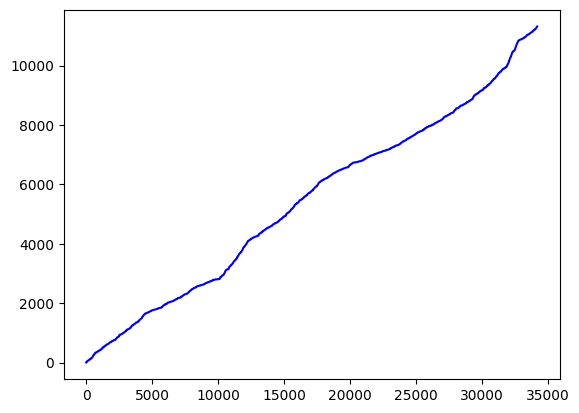

In [17]:

import matplotlib.pyplot as plt
#准备绘制数据
x = list(range(0, len(substance_reaction)))
# "g" 表示红色，marksize用来设置'D'菱形的大小
plt.plot(x, substance_reaction, "b", markersize=5, label="")